# Tutorial

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import hucira as hc

import warnings
from tqdm import TqdmWarning

warnings.simplefilter("ignore", TqdmWarning)

import time
start = time.time()

# The Human Cytokine Dictionary

The Human Cytokine Dictionary (hcd) can be accessed through this module. Your query data should be a transcriptomic data object in AnnData's .h5ad format with gene symbols in .var axis and metadata describing immune celltypes and experimental conditions of samples. Using the Human Cytokine Dictionary as reference, you can "look up" cytokine responses of the disease states in your own dataset.

# 1. Load input data

The two main input files for this tool are:
1. the Human Cytokine Dictionary 
2. your transcriptome data object

Explore their metadata annotation for cell types and disease condition.

In [2]:
#### Load the human cytokine dictionary

df_hcd_all = hc.load_human_cytokine_dict()

print(f"All celltypes in dictionary:\n  {df_hcd_all.celltype.unique()}")
print("\n")
print(f"All cytokines in dictionary:\n  {df_hcd_all.cytokine.unique()}")

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/human_cytokine_dict.csv
All celltypes in dictionary:
  ['Intermediate_B_cell' 'NKT' 'CD8_Memory_T_cell' 'NK_CD56low' 'CD16_Mono'
 'NK_CD56hi' 'CD8_Naive_T_cell' 'pDC' 'ILC' 'MAIT' 'Naive_B_cell'
 'CD4_Naive_T_cell' 'Treg' 'Plasmablast' 'Granulocyte' 'B_cell'
 'CD4_T_cell' 'HSPC' 'CD8_T_cell' 'CD14_Mono' 'cDC' 'CD4_Memory_T_cell'
 'NK' 'Mono']


All cytokines in dictionary:
  ['4-1BBL' 'ADSF' 'APRIL' 'BAFF' 'C3a' 'C5a' 'CD27L' 'CD30L' 'CD40L' 'CT-1'
 'Decorin' 'EGF' 'EPO' 'FGF-beta' 'FLT3L' 'FasL' 'G-CSF' 'GDNF' 'GITRL'
 'GM-CSF' 'HGF' 'IFN-alpha1' 'IFN-beta' 'IFN-epsilon' 'IFN-gamma'
 'IFN-lambda1' 'IFN-lambda2' 'IFN-lambda3' 'IFN-omega' 'IGF-1'
 'IL-1-alpha' 'IL-1-beta' 'IL-10' 'IL-11' 'IL-12' 'IL-13' 'IL-15' 'IL-16'
 'IL-17A' 'IL-17B' 'IL-17C' 'IL-17D' 'IL-17E' 'IL-17F' 'IL-18' 'IL-19'
 'IL-1Ra' 'IL-2' 'IL-20' 'IL-21' 'IL-22' 'IL-23' 'IL-24' 'IL-26' 'IL-27'
 'IL-3' 'IL-31' 'IL-32-beta' 'IL-33' 'IL-34' 'IL-3

In [3]:
#### Load the query adata object

adata = hc.load_MS_CSF_data()
adata

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/MS_CSF.h5ad


AnnData object with n_obs × n_vars = 65326 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

In [4]:
#### Optional for easy workflow:
# Enter celltype column name and condition column name

your_celltype_colname = "labels"
your_contrast_colname = "MS"


# Check data size (Are the conditions you want to contrast of comparable size?)
adata.obs[your_contrast_colname].value_counts()

MS
True     35483
False    29843
Name: count, dtype: int64

In [5]:
# Enrichment analysis needs two main information from query adata: cell types and disease conditions.
# They have to be chosen manually, because annotation of objects differs.

print(f"All celltypes in query data:\n  {sorted(adata.obs[your_celltype_colname].unique())}\n")
print(f"All experimental states (contrasts/conditions) in query data:\n  {sorted(adata.obs[your_contrast_colname].unique())}\n")

All celltypes in query data:
  ['B cell doublets', 'B1', 'B2', 'CD4', 'CD8a', 'CD8n', 'Gran', 'MegaK', 'Mono', 'Mono Doublet', 'NK1', 'NK2', 'RBC', 'Tdg', 'Tregs', 'contamination1', 'doublet', 'mDC1', 'mDC2', 'ncMono', 'pDC', 'plasma']

All experimental states (contrasts/conditions) in query data:
  ['False', 'True']



# 2. Process and prepare input data parameters

1. Convert ENSG to gene symbols if necessary
2. Because there is no standard nomenclature for cell types, we have to manually create **"celltype_combos"**, the data container that matches the cell types of your query data to the cell types of the hcd.
3. Choose the experimental conditions of interest (**"contrasts"**)

In [6]:
#### Create celltype_combos. An input parameter for the enrichment analysis.

adata_celltypes = ["B1", "CD8a", "Mono"]
hcd_celltypes = ["B_cell", "CD8_T_cell", "CD14_Mono"]

celltype_combos = hc.create_celltype_combos(adata_celltypes, hcd_celltypes)
celltype_combos

(('B1', 'B_cell'), ('CD8a', 'CD8_T_cell'), ('Mono', 'CD14_Mono'))

In [7]:
#### Define conditions of interest:

contrasts = [("True", "False")]

# 3. Run enrichment analysis

The main analysis is done by run_one_enrichment_test(), which computes enrichment scores of one query celltype and different conditions. 
This simple example returns an example of the main outcome of this cytokine enrichment score analysis. <br>

1. *run_one_enrichment_test()* returns enrichment results for one celltype and contrast.
2. *get_robust_significant_results()* returns the robust and significant results from that initial enrichment analysis.


In [8]:
#### Run enrichment analysis on a single celltype and condition:

print(f"You're running enrichment for: {celltype_combos[0]}.")

enrichment_results = hc.run_one_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combo=celltype_combos[0],
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=1.0,
    threshold_expression=0.05,
    threshold_pval=0.01
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

You're running enrichment for: ('B1', 'B_cell').
Using precomputed stats
True_vs_False


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
1,B1 (B_cell),IL-15,True_vs_False,upregulated,0.51456,1.358139,0.089196,0.38297,0.277,0.195402
2,B1 (B_cell),IFN-beta,True_vs_False,upregulated,0.408754,1.282264,0.126031,0.329497,0.417,0.304054
3,B1 (B_cell),IFN-omega,True_vs_False,upregulated,0.431261,1.192433,0.236386,0.370069,0.62,0.264368
4,B1 (B_cell),IL-13,True_vs_False,upregulated,0.38508,1.07523,0.381841,0.471583,0.795,0.359375
5,B1 (B_cell),IL-4,True_vs_False,upregulated,0.290992,0.985433,0.506315,0.507435,0.903,0.331818
0,B1 (B_cell),IL-1-beta,True_vs_False,upregulated,-0.490166,-1.534729,0.068493,0.048579,0.079077,0.405405


In [9]:
#### Lastly, get robust and significant results from previous enrichment_results

robust_results_dict = hc.get_robust_significant_results(
    results=enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Contrast:True_vs_False


celltype_combo,B1 (B_cell)
cytokine,
IFN-beta,1.282264
IFN-omega,1.192433
IL-1-beta,-1.534729
IL-13,1.075230
IL-15,1.358139
IL-4,0.985433


# 4. Visualization of results


 *run_all_enrichment_test()* iterates the enrichment analysis over several cell types and gene set thresholds for the enrichment analysis, resuting in more robust results. The output is ideal for visualization of:

1. Heatmaps, representing normalized enrichment scores and significant annotations.
2. Cell-cell communication plot, representing cell communication through cytokines.

In [10]:
#### Run more robust enrichment analysis on a several celltypes and conditions:

all_enrichment_results = hc.run_all_enrichment_test(
    adata=adata,
    df_hcd_all=df_hcd_all,
    contrasts_combo=contrasts,
    celltype_combos=celltype_combos,
    contrast_column=your_contrast_colname,
    celltype_column=your_celltype_colname,
    direction="upregulated",
    threshold_lfc=[0.8, 1],
    threshold_expression=[0.05, 0.01],
)

# Look at all enrichment results (reduced view to columns of interest, not all statistics)
all_enrichment_results[
    [
        "celltype_combo",
        "cytokine",
        "contrast",
        "direction",
        "ES",
        "NES",
        "NOM p-val",
        "FDR q-val",
        "FWER p-val",
        "frac_shared_genes_signature",
    ]
].sort_values("NES", ascending=False)

Using precomputed stats
True_vs_False
Using precomputed stats
True_vs_False
Using precomputed stats
True_vs_False
Using precomputed stats
True_vs_False


2025-12-16 23:06:38,140 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:40,195 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:42,066 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:44,015 [WARNING] Duplicated values found in preranked stats: 0.01% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:46,723 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:48,659 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:51,475 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


2025-12-16 23:06:54,009 [WARNING] Duplicated values found in preranked stats: 0.02% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Using precomputed stats
True_vs_False


,celltype_combo,cytokine,contrast,direction,ES,NES,NOM p-val,FDR q-val,FWER p-val,frac_shared_genes_signature
0,CD8a (CD8_T_cell),IL-2,True_vs_False,upregulated,0.612847,2.079503,0.0,0.0,0.0,0.509091
0,CD8a (CD8_T_cell),IL-15,True_vs_False,upregulated,0.600123,2.063562,0.0,0.0,0.0,0.484940
1,CD8a (CD8_T_cell),IL-2,True_vs_False,upregulated,0.62742,2.024465,0.0,0.0,0.0,0.502994
1,CD8a (CD8_T_cell),IL-15,True_vs_False,upregulated,0.561243,1.987817,0.0,0.0,0.0,0.497899
0,CD8a (CD8_T_cell),IL-2,True_vs_False,upregulated,0.576176,1.846478,0.0,0.0,0.0,0.749091
...,...,...,...,...,...,...,...,...,...,...
0,B1 (B_cell),IL-1-beta,True_vs_False,upregulated,-0.490166,-1.534729,0.068493,0.048579,0.079077,0.405405
3,CD8a (CD8_T_cell),Leptin,True_vs_False,upregulated,-0.520795,-1.537655,0.062147,0.083216,0.078947,0.454545
0,B1 (B_cell),IL-10,True_vs_False,upregulated,-0.551575,-1.578424,0.025773,0.242593,0.112139,0.371429
0,Mono (CD14_Mono),C5a,True_vs_False,upregulated,-0.551058,-1.598823,0.055085,0.073059,0.057716,0.146341


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Contrast:True_vs_False


celltype_combo,B1 (B_cell),CD8a (CD8_T_cell),Mono (CD14_Mono)
cytokine,,,
C5a,NaN,NaN,-1.453813
CD40L,1.411431,NaN,NaN
GM-CSF,NaN,NaN,1.192261
IFN-alpha1,NaN,1.229407,-0.069327
IFN-beta,1.222839,1.271918,0.915336
IFN-epsilon,NaN,NaN,-2.086986
IFN-gamma,-0.847659,1.233134,0.846887
IFN-lambda3,0.860390,-1.530068,0.767250
IFN-omega,1.304671,1.390692,0.936681


Contrast that was plotted in this example: True_vs_False


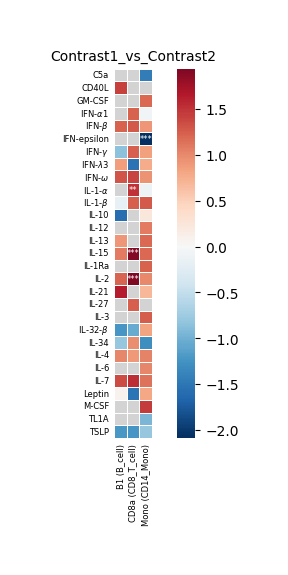

In [11]:
#### Create heatmap to visualize up-/down regulation of cytokines in all queried cell types for one contrast comparison.

robust_results_dict = hc.get_robust_significant_results(
    results=all_enrichment_results,
    alphas=[0.1, 0.05, 0.01],
    threshold_valid=0.1,
    threshold_below_alpha=0.9,
    display_df_nicely=True,
)


contrast_one = all_enrichment_results.contrast.unique()[0]  # Can be looked up manually
print(f"Contrast that was plotted in this example: {contrast_one}")

hc.plot_significant_results(
    results_pivot=robust_results_dict[contrast_one][0],
    df_annot=robust_results_dict[contrast_one][1],
    fontsize=6,
    save_fig=False,
    fig_path="",
)

Loading from: /ictstr01/home/icb/jenni.liu/all_projects/cytokine_dict_project/cytokine_info.xlsx
None of the cytokine producing genes (['IL1A']) were found in dataset for cytokine IL-1-alpha.
None of the cytokine receptor genes (['IL1R1' 'IL1RAP']) were found in dataset for cytokine IL-1-alpha.
None of the cytokine producing genes (['IFNE']) were found in dataset for cytokine IFN-epsilon.


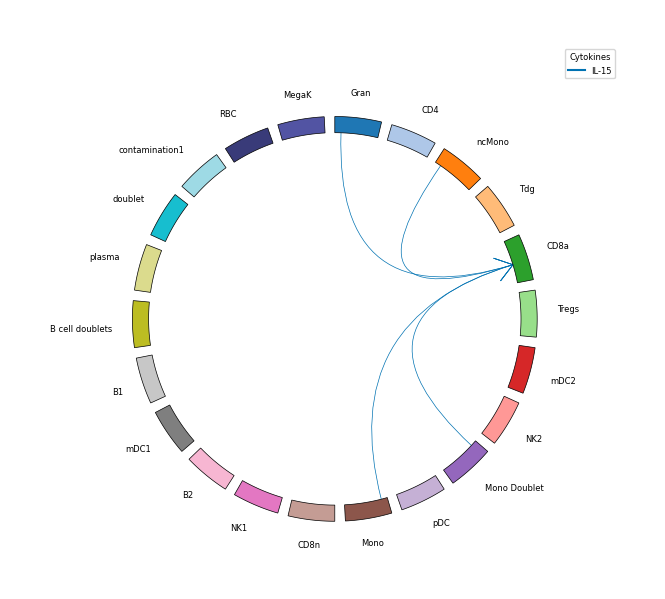

In [12]:
#### Cell-cell communication

cytokine_info = hc.load_cytokine_info()

expression_threshold = 0.1 / 10_000  # = 100 TPM
expression_threshold = np.log2((expression_threshold) + 1)

# Compute cytokine senders and receivers per cell type.
df_senders, df_receivers = hc.get_all_senders_and_receivers(
    adata=adata,
    cytokine_info=cytokine_info,
    cytokine_list=robust_results_dict[contrast_one][2].cytokine.unique(),
    celltype_colname=your_celltype_colname,
    sender_pvalue_threshold=0.1,
    receiver_mean_X_threshold=0,
)

# Plots cell-cell communication
legend_handles, legend_labels = hc.plot_communication(
    df_src=df_senders,
    df_tgt=df_receivers,
    frac_expressing_cells_sender=0,
    frac_expressing_cells_receiver=0,
    mean_cytokine_gene_expression_sender=expression_threshold,
    mean_cytokine_gene_expression_receiver=expression_threshold,
    df_enrichment=robust_results_dict[contrast_one][2],
    all_celltypes=np.array(adata.obs[your_celltype_colname].unique()),
    show_legend=True,
    figsize=(6, 7),
    lw=0.5,
    fontsize=6,
    bbox_to_anchor=(1.1, 1.1),
    loc="center",
)

In [13]:
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Time: 1 min 40 sec


In [ ]:
## --END-- ##